In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from mpl_toolkits.basemap import Basemap
from matplotlib import colors
import scipy as sc, scipy.io
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cbook
from matplotlib.colors import LightSource

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot

%matplotlib inline

/home/imachuca/anaconda3/envs/gsw/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
idealf = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_for_agrif.nc')
ideal = idealf['Bathymetry'][:]
realf = nc.Dataset('/ocean/imachuca/Canyons/runs_mackenzie_canyon/prepare_real_bathy/real_bathy_for_agrif_fix.nc')
real = realf['Bathymetry'][:]
coordsf = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/NEMO_files/coords_for_agrif.nc')
maskfi = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_base/mesh_mask.nc')
maskfr = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/extended_domain/real_base/mesh_mask.nc')

In [3]:
nav_lat = maskfr['nav_lat'][:]
nav_lon = maskfr['nav_lon'][:]

nav_lat.min(), nav_lat.max(), nav_lon.min(), nav_lon.max()

(68.40502, 72.69578, -150.76591, -132.92242)

# Figure - Map

https://matplotlib.org/basemap/users/stere.html

https://matplotlib.org/basemap/api/basemap_api.html

https://bitbucket.org/canyonsubc/mackenzie_canyon/src/default/tools/functions_plot.py

https://bitbucket.org/canyonsubc/analysis_mackenzie_canyon/src/default/notebooks/presentations/

https://www.kennethmoreland.com/color-maps/


In [4]:
#x_region, y_region, z_region = functions_plot.def_regionG(xl=-141.6, xr=-135.7, yb=69.1, yt=70.9)
#X, Y = np.meshgrid(x_region, y_region)

#ax2 = fig.add_subplot(1, 2, 2, projection='3d')
#ls = LightSource(270, 45)
#rgb = ls.shade(z_region, cmap=cmap, vert_exag=0.8, blend_mode='overlay', vmin=-3865, vmax=2370)
#surf = ax2.plot_surface(X, Y, z_region, rstride=1, cstride=1, facecolors=rgb, linewidth=0, antialiased=False, shade=False)
#ax2.set_xticks([])
#ax2.set_yticks([])
#ax2.grid(True)
#ax2.view_init(elev=40, azim=90)

In [5]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        (vmin,), _ = self.process_value(self.vmin)
        (vmax,), _ = self.process_value(self.vmax)
        resdat = np.asarray(result.data)
        result = np.ma.array(resdat, mask=result.mask, copy=False)
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        res = np.interp(result, x, y)
        result = np.ma.array(res, mask=result.mask, copy=False)
        if is_scalar:
            result = result[0]
        return result

In [6]:
# https://superdevresources.com/tools/color-shades#8b7765
list_ocean = ['#f7fcf0','#a8ddb5','#7bccc4','#4eb3d3','#2b8cbe','#0868ac','#084081'] #2,3 - ,'#e0f3db','#ccebc5'
colour_list = list_ocean
cmap = LinearSegmentedColormap.from_list('mycmap', colour_list, N=500, gamma=1)

levels_p = np.concatenate((np.arange(0, 80, 20), np.linspace(80, 5500, 30)), axis=0)
levels_c = [40, 80, 220, 506, 1300]

In [7]:
def plot_arctic(ax, cmap, levels_p, levels_c, nav_lon, nav_lat):
    
    m = Basemap(width=7000000, height=7000000, resolution='i',projection='stere',
                  lat_ts=90, lat_0=90, lon_0=-138., ax=ax)
    
    m.drawcoastlines()
    m.drawlsmask(land_color='#8b7765', ocean_color='#9DA2AB', lakes=True)
    m.fillcontinents(color='#8b7765', alpha=1, zorder=3)
    m.drawcountries(linewidth=2, linestyle='-', color='#4C4138', zorder=4)
    m.drawstates(linewidth=2, linestyle='--', color='#4C4138', zorder=4)
    m.drawparallels(np.arange(-80.,81.,2.0), labels=[False,False,False,False], color='#D9CFC1', zorder=4)#0.5
    m.drawmeridians(np.arange(-180.,181.,5.0), labels=[False,False,False,False], color='#D9CFC1', zorder=4)#1.5
    
    ibcao_file = scipy.io.netcdf_file('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/data/IBCAO_V3_30arcsec_RR.grd')
    x = ibcao_file.variables['x'][:]
    y = ibcao_file.variables['y'][:]
    z = ibcao_file.variables['z'][:]
    
    X, Y = np.meshgrid(x, y) 
    lon, lat = m(X, Y) 
    z_positive = -1 * z
    p = m.contourf(lon, lat, z_positive, cmap=cmap, levels=levels_p, zorder=1)
    c = m.contour(lon, lat, z_positive, levels=levels_c, colors='k', alpha=0.3, zorder=2)
    
    cd, lwd = 'k', 2.0
    nav_lon_d, nav_lat_d = m(nav_lon, nav_lat)
    ax.plot((nav_lon_d[0, 0], nav_lon_d[0, -1]), (nav_lat_d[0, 0], nav_lat_d[0, -1]), c=cd, lw=lwd, zorder=5)
    ax.plot((nav_lon_d[0, 0], nav_lon_d[-1, 0]), (nav_lat_d[0, 0], nav_lat_d[-1, 0]), c=cd, lw=lwd, zorder=5)
    ax.plot((nav_lon_d[-1, -1], nav_lon_d[-1, 0]), (nav_lat_d[-1, -1], nav_lat_d[-1, 0]), c=cd, lw=lwd, zorder=5)
    ax.plot((nav_lon_d[-1, -1], nav_lon_d[0, -1]), (nav_lat_d[-1, -1], nav_lat_d[0, -1]), c=cd, lw=lwd, zorder=5)
    
    print('plot_arctic')
    
    return ax

In [57]:
def plot_region(ax, cmap, levels_p, levels_c, nav_lon, nav_lat):
    
    lw, ms, fs_numb, fs_str, fs = 2.5, 12, 25, 30, 20

    ticks = np.concatenate((np.array([0, 80]), np.arange(500, np.max(levels_p)+500, 500)), axis=0)

    #width=1600000, height=650000
    m = Basemap(width=1300000, height=600000, resolution='i',projection='stere',
                  lat_ts=70, lat_0=70.5, lon_0=-138., ax=ax)
    m.drawcoastlines()
    #m.drawlsmask(land_color='#8b7765', ocean_color='#9DA2AB', lakes=True)
    m.fillcontinents(color='#8b7765', alpha=1, zorder=3)
    m.drawcountries(linewidth=2, linestyle='-', color='#4C4138', zorder=4)
    m.drawstates(linewidth=2, linestyle='--', color='#4C4138', zorder=4)
    m.drawparallels(np.arange(-80.,81.,2.0), labels=[True,False,False,False], color='#D9CFC1', zorder=4)#0.5
    m.drawmeridians(np.arange(-180.,181.,5.0), labels=[False,False,True,False], color='#D9CFC1', zorder=4)#1.5
    ax.tick_params(color='k', labelsize=fs_numb)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)

    x_region, y_region, z_region = functions_plot.def_regionG(xl=-165, xr=-115, yb=66, yt=74)
    X, Y = np.meshgrid(x_region, y_region) 
    lon, lat = m(X, Y) 
    z_positive = -1 * z_region

    p = m.contourf(lon, lat, z_positive, cmap=cmap, levels=levels_p, zorder=1)
    c = m.contour(lon, lat, z_positive, levels=levels_c, colors='k', alpha=0.3, zorder=2)
    plt.clabel(c, inline=1, fontsize=fs_numb, fmt='%1.f', inline_spacing=16)
    cbar = m.colorbar(p,location='right',pad="5%")
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(ticks)
    cbar.set_label('Depth [m]', fontsize=fs_str)

    a='center'

    ax.annotate('Barrow\nCanyon', xy=(m(-151.5, 72.2)), fontsize=fs, va=a, ha=a)
    ax.annotate('Mackenzie\nCanyon', xy=(m(-140.5, 71)), fontsize=fs, va=a, ha=a)
    ax.annotate('Tuktoyaktuk\nPeninsula', xy=(m(-131.2, 69.1)), fontsize=fs, va=a, ha=a)
    ax.annotate('Herschel\nIsland', xy=(m(-139.6, 69.3)), fontsize=fs, va=a, ha=a)
    ax.annotate('Amundsen\nGulf', xy=(m(-125, 71)), fontsize=fs, va=a, ha=a)
    ax.annotate('Mackenzie Shelf', xy=(m(-130.5, 70.25)), fontsize=fs, va=a, ha=a, rotation=26)
    ax.annotate('Beaufort Shelf', xy=(m(-148.05, 70.62)), fontsize=fs, va=a, ha=a, rotation=325)
    ax.annotate('Mackenzie\nDelta', xy=(m(-136, 69.7)), fontsize=fs, va=a, ha=a)
    ax.annotate('Mackenzie\nRiver', xy=(m(-132, 68.2)), fontsize=fs, va=a, ha=a)

    lons_mooring = [-139.983, -136.817, -138.383, -138.183, -127.315, -128.45, -134.485, -138.613]
    lats_mooring = [70.533, 70.55, 69.9, 69.517, 70.767, 71.48, 70.962, 69.972]
    name_mooring = ['A', 'B', 'C', 'D', 'SS1', 'SS2', 'SS3', 'SS4']
    for xm, ym, name in zip(lons_mooring, lats_mooring, name_mooring):
        xmd, ymd = m(xm, ym)
        ax.scatter(xmd, ymd, c='k')
        if name == 'A' or name == 'B' or name == 'C' or name == 'D':
            xmd, ymd = m(xm+0.33, ym-0.05)
            ax.annotate(name, xy=(xmd, ymd), fontsize=fs_str, va='center', ha='center')
        else:
            xmd, ymd = m(xm-0.24, ym+0.15)
            ax.annotate(name, xy=(xmd, ymd), fontsize=fs_str, va='center', ha='center')
    
    cd, lwd = 'k', 3.5
    nav_lon_d, nav_lat_d = m(nav_lon, nav_lat)
    ax.plot((nav_lon_d[0, 0], nav_lon_d[0, -1]), (nav_lat_d[0, 0], nav_lat_d[0, -1]), c=cd, lw=lwd, zorder=5)
    ax.plot((nav_lon_d[0, 0], nav_lon_d[-1, 0]), (nav_lat_d[0, 0], nav_lat_d[-1, 0]), c=cd, lw=lwd, zorder=5)
    ax.plot((nav_lon_d[-1, -1], nav_lon_d[-1, 0]), (nav_lat_d[-1, -1], nav_lat_d[-1, 0]), c=cd, lw=lwd, zorder=5)
    ax.plot((nav_lon_d[-1, -1], nav_lon_d[0, -1]), (nav_lat_d[-1, -1], nav_lat_d[0, -1]), c=cd, lw=lwd, zorder=5)


    print(nav_lon_d[0, 0], nav_lon_d[-1, -1], nav_lon_d[0, -1], nav_lon_d[-1, 0])
    
    print(nav_lat_d[0, 0], nav_lat_d[-1, -1], nav_lat_d[0, -1], nav_lat_d[-1, 0])                                                        
    
    #plt.show()
    print('plot_region')
    return ax

In [60]:
def plot_3d(ax):
    x_region, y_region, z_region = functions_plot.def_regionS(xl=-1600e3, xr=-1300e3, yb=1500e3, yt=1780e3)
    #x_region, y_region, z_region = functions_plot.def_regionS(xl=-1698e3, xr=-1102e3, yb=1348e3, yt=19575e2)
    X, Y = np.meshgrid(x_region, y_region)
    ls = LightSource(270, 45)
    
    rgb = ls.shade(z_region, cmap=cm.gist_earth, vert_exag=0.8, blend_mode='overlay', vmin=-3000, vmax=1000)
    surf = ax.plot_surface(X, Y, z_region, rstride=1, cstride=1, facecolors=rgb, linewidth=0, antialiased=False, shade=False)
    ax.view_init(elev=40)
    
    ax.text(-1450000, 1750000, 800, 'Canadian Arctic\nCoast', None, fontsize=30)
    ax.text(-1570000, 1650000, -250, 'Mackenzie\nCanyon', None, fontsize=30)
    ax.text(-1570000, 1550000, -2300, 'Deep\nOcean', None, fontsize=30)
    
    print('plot_3d')
    return ax

plot_arctic
plot_3d
850493.4649441652 209188.80044422293 248785.5210399934 809904.6611625799
161501.69284818796 488911.01113478886 99368.47280793326 550599.7491981233
plot_region


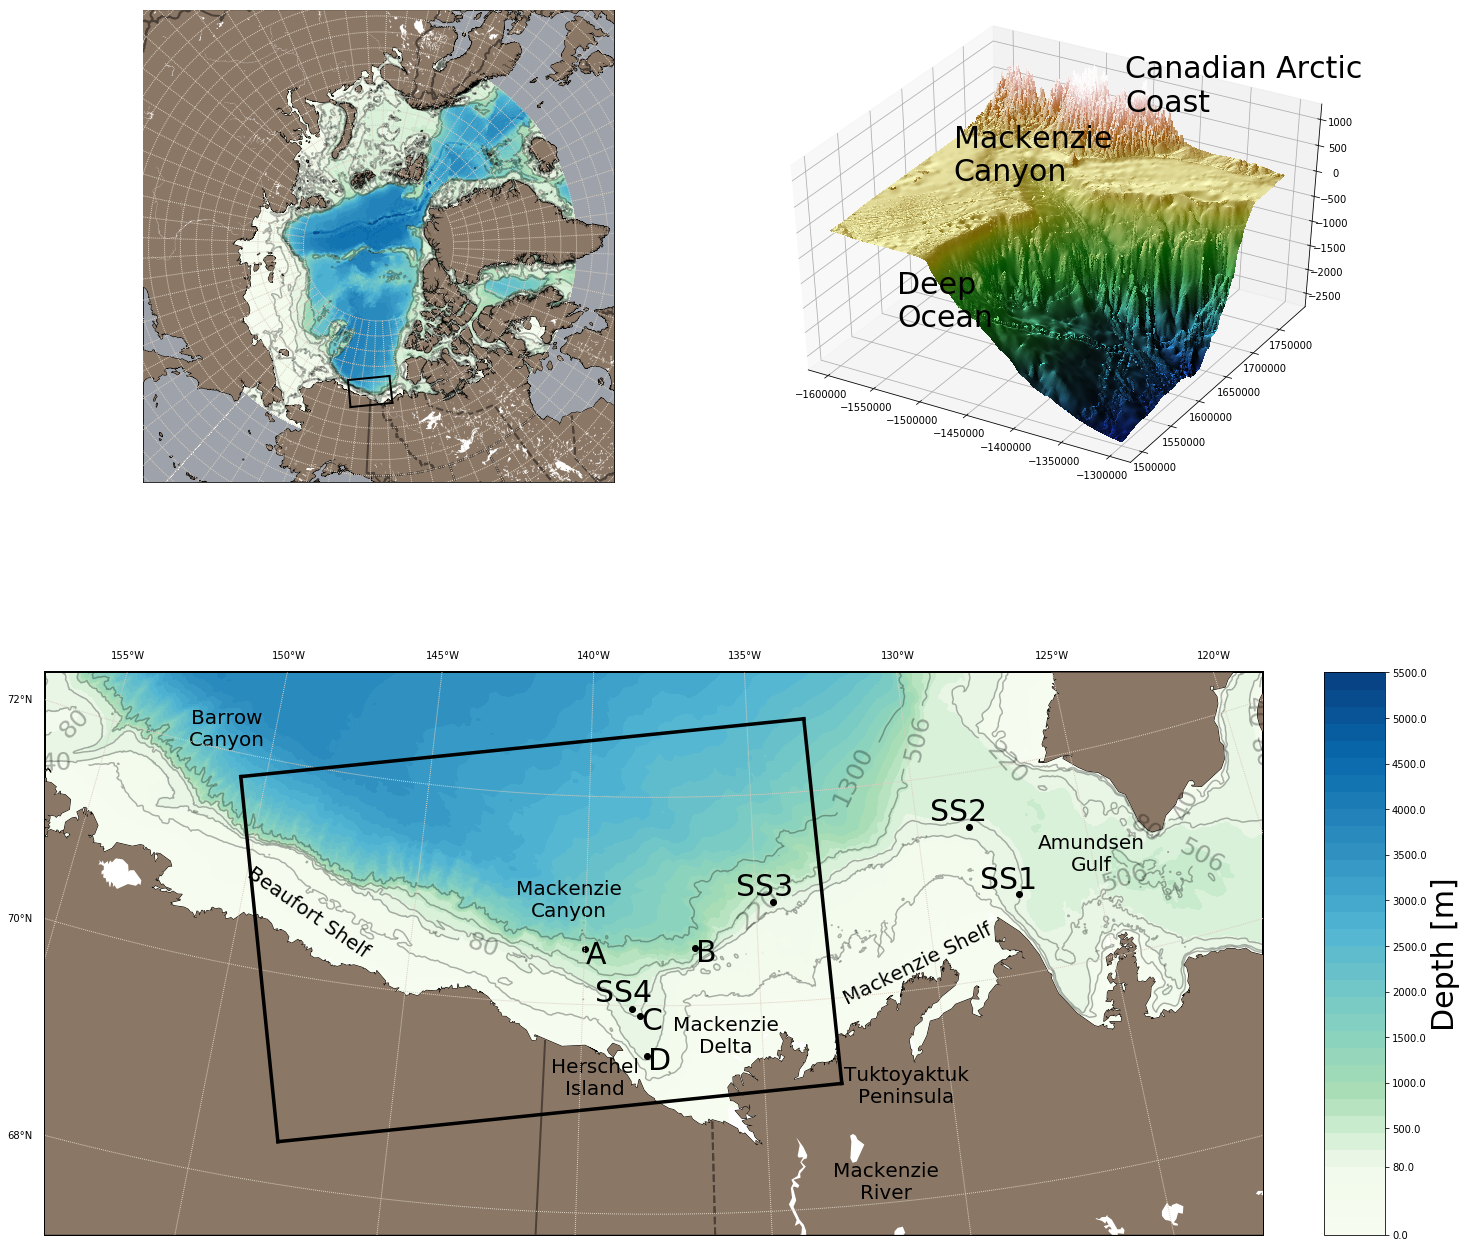

In [61]:
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[2,4])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], projection='3d')
ax3 = fig.add_subplot(gs[1, :])

ax1 = plot_arctic(ax1, cmap, levels_p, levels_c, nav_lon, nav_lat)
ax2 = plot_3d(ax2)
ax3 = plot_region(ax3, cmap, levels_p, levels_c, nav_lon, nav_lat)

gs.tight_layout(fig)
gs.update(wspace=0.008, hspace=0.001)
fig.savefig('./map_Beaufort.png', dpi=100, bbox_inches='tight')